In [1]:
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import keras_tuner as kt
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
with open(r'.\News_Dataset_Splits\X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open(r'.\News_Dataset_Splits\X_val.pkl', 'rb') as f:
    X_val = pickle.load(f)

with open(r'.\News_Dataset_Splits\X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open(r'.\News_Dataset_Splits\y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open(r'.\News_Dataset_Splits\y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)

with open(r'.\News_Dataset_Splits\y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

encoder = LabelEncoder()
encoder.fit(np.unique(y_train))
train_labels = encoder.transform(y_train)
val_labels = encoder.transform(y_val)
test_labels = encoder.transform(y_test)
num_classes = len(encoder.classes_)
train_one_hot = keras.utils.to_categorical(train_labels, num_classes=num_classes)
val_one_hot = keras.utils.to_categorical(val_labels, num_classes=num_classes)
test_one_hot = keras.utils.to_categorical(test_labels, num_classes=num_classes)

with open(r'.\embeddingMatrix_News.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)

num_tokens = len(embedding_matrix) # total vocabulary +1 or length of embedding matrix
embedding_dim = 300 # dimension of the vector of a single word
MAX_NEWS_LEN = 500 # maximum words in a review

In [3]:
def build_model(hp):
    embedding_layer = keras.layers.Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        input_length=MAX_NEWS_LEN,
        trainable=True)
    
    model = keras.Sequential()
    model.add(embedding_layer)
    model.add(keras.layers.GlobalAveragePooling1D())

    model.add(layers.Dense(units=128, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dropout(rate=0.2))
    
    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = hp.Choice('optimizer', ['Adamax'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
NUM_EPOCHS = 20
BATCH_SIZE = 128

now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
directory = f'KerasTuner_Logs/FNN/FNN_BestModel_{now}'

# Callbacks
tensorboard = TensorBoard(log_dir=f'TensorBoard_Logs/FNN/FNN_BestModel_{now}')
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

tuner = kt.GridSearch(
    lambda hp: build_model(hp),
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=None,
    executions_per_trial=3,
    directory=directory,
    project_name='Reviews_Classification')

In [5]:
tuner.search(x=X_train,
             y=train_one_hot,
             verbose=1,
             epochs=NUM_EPOCHS,
             batch_size=BATCH_SIZE,
             callbacks=[tensorboard, early_stopping],
             validation_data=(X_val, val_one_hot))

Trial 1 Complete [00h 07m 35s]
val_loss: 0.5132549603780111

Best val_loss So Far: 0.5132549603780111
Total elapsed time: 00h 07m 35s


In [10]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
best_model = tuner.get_best_models(num_models=1)[0]

In [10]:
from keras.models import load_model

# Specify the path to your .h5 model file
model_path = 'SavedModels/dir_2024-07-04_16-19-08/best_model.h5'

# Load the model
s_model = load_model(model_path)

In [22]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score: ", score[0])
print("Test accuracy: ", score[1])

680/680 [==============================] - 2s 2ms/step - loss: 1.6096 - accuracy: 0.1938
Test score:  1.609615683555603
Test accuracy:  0.19383907318115234


In [11]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_actuals = np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_actuals, y_prediction , normalize='pred')
print(result)

680/680 [==============================] - 1s 1ms/step
[[0.62162736 0.18747373 0.05969773 0.01919846 0.03495661]
 [0.21967283 0.45964691 0.18664987 0.05663547 0.03471553]
 [0.08200552 0.23539302 0.47078086 0.18142549 0.05834137]
 [0.03441683 0.07776377 0.21763224 0.4838013  0.22299904]
 [0.04227746 0.03972257 0.06523929 0.25893928 0.64898746]]


In [12]:
accuracy_score = metrics.accuracy_score(y_prediction, y_actuals)

print('FNN accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_actuals, y_prediction)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_actuals, y_prediction))

FNN accuracy is 53.75%
------------------------------------------------
Confusion Matrix:
      0     1     2     3     4
0  2926   892   237    80   145
1  1034  2187   741   236   144
2   386  1120  1869   756   242
3   162   370   864  2016   925
4   199   189   259  1079  2692
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.68      0.65      4280
           1       0.46      0.50      0.48      4342
           2       0.47      0.43      0.45      4373
           3       0.48      0.46      0.47      4337
           4       0.65      0.61      0.63      4418

    accuracy                           0.54     21750
   macro avg       0.54      0.54      0.54     21750
weighted avg       0.54      0.54      0.54     21750



In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

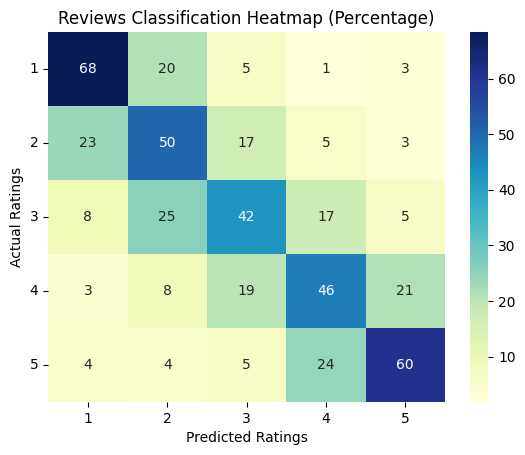

In [19]:
# Create a confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes))
for i in range(len(y_prediction)):
    confusion_matrix[y_actuals[i], y_prediction[i]] += 1

# Normalize the confusion matrix to show percentages
confusion_matrix = 100 * confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

lables = [1, 2, 3, 4, 5]
# Create a heatmap with annotation
annot_matrix = np.around(confusion_matrix, 1).astype(int)  # Round percentages to 1 decimal place
ax = sns.heatmap(confusion_matrix, annot=annot_matrix, fmt='d', cmap="YlGnBu", xticklabels=lables, yticklabels=lables)

# Set the title and axis labels
plt.title("Reviews Classification Heatmap (Percentage)")
plt.xlabel("Predicted Ratings")
plt.ylabel("Actual Ratings")

# Rotate the x-axis labels for better visibility
plt.yticks(rotation=0)

# Display the heatmap
plt.show()